### Import libraries

In [1]:
import numpy as np
import gym
import random
from hyperopt import fmin, tpe,hp
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

### Define some parameters

In [13]:
env = gym.make("FrozenLake-v0")     # initiate the environment

action_size = env.action_space.n         # number of possible actions
state_size = env.observation_space.n     # number of possible states


Ntrials = 15000             # Number of experiments
max_iters = 100              # Maximum iterations at each experiment

max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.01            # Minimum exploration probability
decay_rate = 0.005            # Exponential decay rate

In [3]:
def exp_decay(N,max_epsilon=1.0,min_epsilon=0.01,decay_rate=0.005):
    """ 
    Exponential decay function to define the probability for epsilon greedy.
    """
    return min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*N)



# Method 1. The Q-Learning algorithm

In [4]:
def Qtable(learning_rate,gamma):
    qtable = np.zeros((state_size, action_size))     # initiate the q-table with zero
    rewards = []
    for N in range(Ntrials):        
        state = env.reset()          # reset environment at the begining of each trial
        total_rewards = 0
        epsilon = exp_decay(N=N)    # probability of explore
        for i in range(max_iters):
    #         action = np.argmax(qtable[state,:] + np.random.randn(1,state_size)*(1./(N+1))) # greedy + noise
            if random.uniform(0,1) > epsilon:                             # greedy epsilon
                action = np.argmax(qtable[state,:])         # exploit
            else:
                action = env.action_space.sample()          # explore

            new_state, reward, done, info = env.step(action)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])

            total_rewards += reward   # sum up the rewards
            state = new_state         # update the state

            if done == True:          # break if it is at goal or at hole
                break

        rewards.append(total_rewards)   # store the reward for each trial
    return(rewards,qtable)

## Here we use hyperopt to find the best learning rate and gamma

In [5]:
def sample_loss(args):
    """
    Loss function that find the total rewards given the learning rate and gamma.
    The goal is tune the learning rate and gamma that gives the highest reward.
    """
 
    learning_rate,gamma = args    # learning rate and gamma as hyper parameter

    rewards,qtable = Qtable(learning_rate,gamma)
        
    print ("args = ({:4.4f},{:4.4f}), Average Score = {:4.2f}".format(learning_rate,gamma,sum(rewards)/Ntrials))
    return 1-sum(rewards)/Ntrials       # return 1-reward (we minimze 1-reward which is equivalent to maximizing reward)



space =[                            # define the possible space for learning rate and gamma
    hp.loguniform('learning_rate',np.log(0.1),np.log(1)),
    hp.loguniform('gamma',np.log(0.1),np.log(1))
]


best = fmin(sample_loss,              # run 
           space = space,
           algo=tpe.suggest,
           max_evals=300)

print(best)

args = (0.3344,0.1639), Average Score = 0.00         
args = (0.2806,0.7203), Average Score = 0.21                   
args = (0.2322,0.1276), Average Score = 0.06                      
args = (0.4073,0.9441), Average Score = 0.51                      
args = (0.7846,0.1409), Average Score = 0.07                                  
args = (0.1076,0.2857), Average Score = 0.08                                  
args = (0.3416,0.3646), Average Score = 0.00                                  
args = (0.7296,0.2108), Average Score = 0.08                                  
args = (0.7352,0.5374), Average Score = 0.19                                  
args = (0.1846,0.1212), Average Score = 0.07                                  
args = (0.1119,0.1875), Average Score = 0.06                                   
args = (0.6940,0.5167), Average Score = 0.14                                   
args = (0.3961,0.1044), Average Score = 0.00                                   
args = (0.2115,0.3357), Average Sc

args = (0.2169,0.7536), Average Score = 0.25                                     
args = (0.2409,0.6008), Average Score = 0.00                                     
args = (0.2547,0.8233), Average Score = 0.30                                     
args = (0.2282,0.8650), Average Score = 0.00                                     
args = (0.2027,0.9363), Average Score = 0.54                                     
args = (0.3140,0.7063), Average Score = 0.23                                     
args = (0.1730,0.7670), Average Score = 0.29                                     
args = (0.2852,0.7949), Average Score = 0.26                                     
args = (0.1947,0.9921), Average Score = 0.00                                     
args = (0.2622,0.9007), Average Score = 0.42                                     
args = (0.2952,0.6261), Average Score = 0.15                                     
args = (0.2359,0.3029), Average Score = 0.07                                     
args = (0.2100,0

## Use the best learning rate and gamma from previous cell to recalculate the qtable 

In [15]:
learning_rate = best['learning_rate']  # Learning rate
gamma = best['gamma']                  # Discounting rate


rewards,qtable = Qtable(learning_rate,gamma)

print ("Average Score: {:4.2f} ".format(sum(rewards)/Ntrials))



Average Score: 0.62 


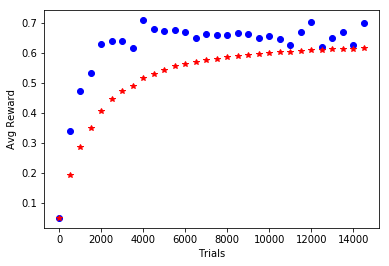

In [16]:
import matplotlib.pyplot as plt
for x in range(0,len(rewards),500):
    plt.plot(x,np.mean(rewards[x:x+500]),'bo')      # average reward for each 500 round
    plt.plot(x,np.mean(rewards[0:x+500]),'r*')      # rolling average 

plt.xlabel('Trials')
plt.ylabel('Avg Reward')
plt.show()

## If we want to use the qtable to play

In [17]:
env.reset()
rewards = []
steps = []
for N in range(Ntrials):
    state = env.reset()
    for i in range(max_iters):
        action = np.argmax(qtable[state,:])
        new_state, reward, done, info = env.step(action)
        if done:
            rewards.append(reward)
            break
        state = new_state
env.close()

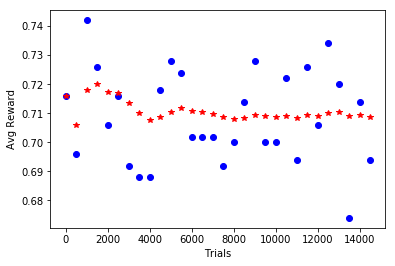

In [18]:
for x in range(0,len(rewards),500):
    plt.plot(x,np.mean(rewards[x:x+500]),'bo')      # average reward for each 500 round
    plt.plot(x,np.mean(rewards[0:x+500]),'r*')      # rolling average 

plt.xlabel('Trials')
plt.ylabel('Avg Reward')
plt.show()

# Method 2. Q-Learning with TensorFlow

In [10]:
Ntrials = 5000
env = gym.make('FrozenLake-v0')
tf.reset_default_graph()
inputs1 = tf.placeholder(shape=[1,state_size],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([state_size,action_size],0,0.01))   # Initiate weights randomly
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)
nextQ = tf.placeholder(shape=[1,action_size],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))                         # Loss function

def Qtable_tf(learning_rate,gamma):
    trainer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    updateModel = trainer.minimize(loss)
    init = tf.global_variables_initializer()

    rewards = []
    with tf.Session() as sess:
        sess.run(init)
        for N in range(Ntrials):
            state = env.reset()
            total_reward = 0
            i = 0
            epsilon = exp_decay(N=N)
            while i < max_iters:
                i+=1
                action,qtable_tf = sess.run([predict,Qout],
                                  feed_dict=
                                  {inputs1:np.identity(state_size)[state:state+1]})
                action = action[0]
                if random.uniform(0,1) < epsilon:
                    action = env.action_space.sample()
                next_state, reward, done, info = env.step(action)
                Q1 = sess.run(Qout,feed_dict=
                              {inputs1:np.identity(state_size)[new_state:new_state+1]})
                maxQ1 = np.max(Q1)
                targetQ = qtable_tf
                targetQ[0,action] = reward + gamma*maxQ1
                _,W1 = sess.run([updateModel,W],
                                feed_dict=\
                                {inputs1:np.identity(state_size)[state:state+1],nextQ:targetQ})
                total_reward += reward
                state = next_state
                if done:
                    break
            rewards.append(total_reward)
    return(rewards)    

def sample_loss(args):
    learning_rate,gamma = args
    rewards = Qtable_tf(learning_rate,gamma)
    print ("args = ({:4.4f},{:4.4f}), Average Score = {:4.2f}".format(learning_rate,gamma,sum(rewards)/Ntrials))
    return 1-sum(rewards)/Ntrials       # return 1-reward (we minimze 1-reward which is equivalent to maximizing reward)

    
space =[                            # define the possible space for learning rate and gamma
    hp.loguniform('learning_rate',np.log(0.1),np.log(1)),
    hp.loguniform('gamma',np.log(0.1),np.log(1))
]


best = fmin(sample_loss,              # run 
           space = space,
           algo=tpe.suggest,
           max_evals=100)

print(best)


Instructions for updating:
Colocations handled automatically by placer.
args = (0.5894,0.2119), Average Score = 0.00         
args = (0.3181,0.1411), Average Score = 0.02                         
args = (0.2931,0.2286), Average Score = 0.03                         
args = (0.4543,0.3306), Average Score = 0.03                         
args = (0.5012,0.1924), Average Score = 0.00                         
args = (0.4123,0.5758), Average Score = 0.03                        
args = (0.2522,0.6583), Average Score = 0.03                        
args = (0.1431,0.2612), Average Score = 0.03                        
args = (0.4422,0.6033), Average Score = 0.03                        
args = (0.4098,0.4976), Average Score = 0.03                        
args = (0.3765,0.7017), Average Score = 0.03                         
args = (0.7704,0.3732), Average Score = 0.00                         
args = (0.2700,0.8117), Average Score = 0.08                         
args = (0.5929,0.2445), Average Score =

In [11]:
rewards = Qtable_tf(best['learning_rate'],best['gamma'])

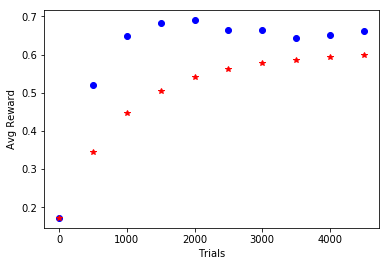

In [12]:
for x in range(0,len(rewards),500):
    plt.plot(x,np.mean(rewards[x:x+500]),'bo')      # average reward for each 500 round
    plt.plot(x,np.mean(rewards[0:x+500]),'r*')      # rolling average 

plt.xlabel('Trials')
plt.ylabel('Avg Reward')
plt.show()